# 01 — Exploration des données
Ce notebook sert à **comprendre la structure** des données (plage temporelle, continuité horaire, valeurs manquantes).

**Entrées attendues** (générées par le pipeline) :
- `data/processed/consommation_clean.parquet`
- (optionnel) `data/processed/weather_national_hourly.parquet`


In [1]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")


Current Working Directory: /home/onyxia/france-grid-stress-prediction


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('.').resolve() 
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_FIG = PROJECT_ROOT / 'outputs' / 'figures'
OUTPUT_FIG.mkdir(parents=True, exist_ok=True)

CONS_PATH = DATA_PROCESSED / 'consommation_clean.parquet'
WEATHER_PATH = DATA_PROCESSED / 'weather_national_hourly.parquet'

CONS_PATH.exists(), WEATHER_PATH.exists()



(True, True)

## 1) Chargement

In [3]:
df_load = pd.read_parquet(CONS_PATH)
df_load['datetime'] = pd.to_datetime(df_load['datetime'])
df_load = df_load.sort_values('datetime').reset_index(drop=True)
df_load.head()

,datetime,load_mw
0,2010-01-01 00:00:00,53067
1,2010-01-01 00:30:00,52303
2,2010-01-01 01:00:00,52272
3,2010-01-01 01:30:00,52013
4,2010-01-01 02:00:00,52099


In [4]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252672 entries, 0 to 252671
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  252672 non-null  datetime64[ns]
 1   load_mw   252672 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.9 MB


In [5]:
df_load[['datetime','load_mw']].describe(include='all')

,datetime,load_mw
count,252672,252672.000000
mean,2017-05-16 12:56:56.717326080,53819.752050
min,2010-01-01 00:00:00,29477.000000
25%,2013-08-08 23:52:30,44733.000000
50%,2017-03-16 23:45:00,52011.000000
75%,2021-05-25 23:37:30,61838.000000
max,2024-12-31 23:30:00,102098.000000
std,NaN,12013.888407


## 2) Couverture temporelle et continuité

In [6]:
start, end = df_load['datetime'].min(), df_load['datetime'].max()
freq_counts = df_load['datetime'].diff().value_counts().head(10)
start, end, freq_counts

(Timestamp('2010-01-01 00:00:00'),
 Timestamp('2024-12-31 23:30:00'),
 datetime
 0 days 00:30:00      252669
 154 days 00:30:00         1
 61 days 00:30:00          1
 Name: count, dtype: int64)

In [7]:
# Vérification des gaps horaires (attendu: 1H)
gaps = df_load['datetime'].diff().dropna()
largest_gaps = gaps.sort_values(ascending=False).head(20)
largest_gaps

181104   154 days 00:30:00
182544    61 days 00:30:00
1          0 days 00:30:00
168451     0 days 00:30:00
168450     0 days 00:30:00
168449     0 days 00:30:00
168448     0 days 00:30:00
168447     0 days 00:30:00
168446     0 days 00:30:00
168453     0 days 00:30:00
168445     0 days 00:30:00
168444     0 days 00:30:00
168443     0 days 00:30:00
168442     0 days 00:30:00
168441     0 days 00:30:00
168440     0 days 00:30:00
168452     0 days 00:30:00
168454     0 days 00:30:00
168438     0 days 00:30:00
168455     0 days 00:30:00
Name: datetime, dtype: timedelta64[ns]

In [8]:
# Nombre de valeurs manquantes sur la cible
df_load['load_mw'].isna().sum()

np.int64(0)

## 3) Visualisations rapides

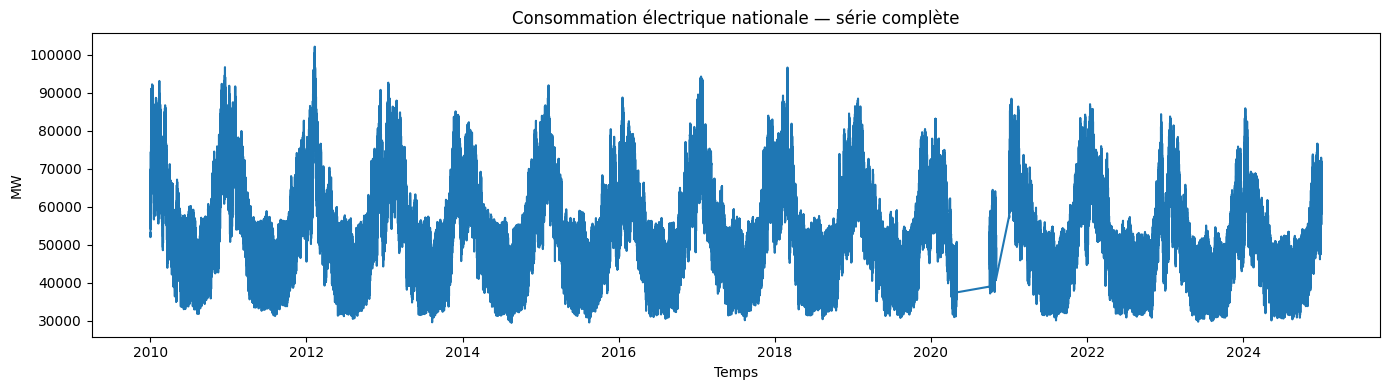

In [9]:
plt.figure(figsize=(14,4))
plt.plot(df_load['datetime'], df_load['load_mw'])
plt.title('Consommation électrique nationale — série complète')
plt.xlabel('Temps')
plt.ylabel('MW')
plt.tight_layout()
plt.savefig(OUTPUT_FIG / 'load_timeseries_full.png', dpi=150)
plt.show()

## 4) Météo agrégée (optionnel)

In [ ]:
if WEATHER_PATH.exists():
    df_w = pd.read_parquet(WEATHER_PATH)
    if 'datetime' in df_w.columns:
        df_w['datetime'] = pd.to_datetime(df_w['datetime'])
    df_w = df_w.sort_values('datetime').reset_index(drop=True)
    display(df_w.head())
    display(df_w.info())
else:
    print('weather_national_hourly.parquet absent — section ignorée.')

,datetime,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,2010-01-01 00:00:00,4.273719,12.397994,0.0,0.0,93.96875
1,2010-01-01 01:00:00,4.036219,12.709288,0.0,0.0,95.40625
2,2010-01-01 02:00:00,3.812781,13.122019,0.0,0.0,96.46875
3,2010-01-01 03:00:00,3.598719,13.308270,0.0,0.0,96.87500
4,2010-01-01 04:00:00,3.426844,14.081800,0.0,0.0,94.78125


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131496 entries, 0 to 131495
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           131496 non-null  datetime64[ns]
 1   temperature_2m     131496 non-null  float64       
 2   wind_speed_10m     131496 non-null  float64       
 3   direct_radiation   131496 non-null  float64       
 4   diffuse_radiation  131496 non-null  float64       
 5   cloud_cover        131496 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 6.0 MB


None